<h1>Chapter 4 | Data Exercise #4 | <code>wms-management-survey</code> | Comparison and correlation</h1>
<h2>Introduction:</h2>
<p>In this notebook, you will find my notes and code for Chapter 5's <b>exercise 3</b> of the book <a href="https://gabors-data-analysis.com/">Data Analysis for Business, Economics, and Policy</a>, by Gábor Békés and Gábor Kézdi. The question was: 
<p>4. Using the <code>wms-management-survey</code> dataset from a country of your choice.</p>
<p>Assignments:</p>
<ul>
    <li>Produce a principal component using all 18 items to form an alternative managment score variable.</li>
    <li>Use this principal component and the simple average management score to produce bin scatters, scatterplots.</li>
    <li>Calculate  conditional statistics to uncover the patterns of their association with employment.</li>
    <li>Compare your results and comment on which `y` measure you would use in presenting them.</li>
</ul>
<h2>1. Load the data</h2>

In [29]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn import set_config
set_config(display="text") # estimators will be displayed as text, not as a diagram (which is the default).

import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
from mizani.formatters import percent_format

warnings.filterwarnings("ignore")
%matplotlib inline

In [30]:
# Increase number of returned rows in pandas
pd.set_option("display.max_rows", 500)

In [31]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_data_exercises")[0]

# Get location folders
data_in = f"{dirname}da_data_repo/wms-management-survey/clean/"
data_out = f"{dirname}da_data_exercises/ch04-comparison_correlation/04-wms_management_ex3/data/clean/"
output = f"{dirname}da_data_exercises/ch04-comparison_correlation/04-wms_management_ex3/"
func = f"{dirname}da_case_studies/ch00-tech_prep/"
sys.path.append(func)

In [32]:
from py_helper_functions import *

In [33]:
df = pd.read_csv(f"{data_in}wms_da_textbook.csv", usecols=[*range(0, 32)]) # exclude logical variables that won't be used in this exercise

## 2. Data Preprocessing ##
We need to select our country, make sure our data is clean and ready for analysis, and select the relevant columns for our PCA.

In [34]:
df["country"].unique()

array(['United States', 'India', 'New Zealand', 'Australia', 'Argentina',
       'Brazil', 'Canada', 'Chile', 'China', 'Germany', 'Spain', 'France',
       'Northern Ireland', 'Great Britain', 'Greece',
       'Republic of Ireland', 'Italy', 'Japan', 'Mexico', 'Poland',
       'Portugal', 'Sweden', 'Singapore', 'Turkey'], dtype=object)

This time, let's pick an Asian country. As the survey apparently selected countries by region for each year.

In [35]:
df_2012 = df.loc[df["wave"] == 2012]
df_2012["country"].value_counts()

country
Singapore    406
Australia     20
Name: count, dtype: int64

Let's pick **Singapore**. We will also limit our firm size to a minimum of 100 and a maximum of 5000 employees.

In [36]:
df["emp_firm"].describe()

count     14243.000000
mean        847.081795
std        3703.285294
min           1.000000
25%         150.000000
50%         280.000000
75%         650.000000
max      176000.000000
Name: emp_firm, dtype: float64

In [37]:
df = df.loc[
    lambda x: (x["country"] == "Singapore") &
              (x["wave"] == 2012) &
              (x["emp_firm"] >= 100) &
              (x["emp_firm"] <= 5000)
]

In [38]:
df["emp_firm"].describe()

count     239.000000
mean      787.347280
std      1152.920421
min       100.000000
25%       160.000000
50%       280.000000
75%       800.000000
max      5000.000000
Name: emp_firm, dtype: float64

In [39]:
df.head()

,firmid,wave,cty,country,sic,management,operations,monitor,target,people,...,talent1,talent2,talent3,talent4,talent5,talent6,emp_firm,firmage,ownership,mne_yn
12572,8882,2012,sg,Singapore,32.0,2.500000,2.5,2.4,2.8,2.333333,...,1.0,3.0,3.0,3.0,2.0,2.0,4700.0,NaN,Dispersed Shareholders,1.0
12574,8884,2012,sg,Singapore,27.0,2.833333,3.0,3.6,3.0,2.000000,...,2.0,2.0,1.0,2.0,3.0,2.0,2000.0,63.0,Dispersed Shareholders,1.0
12577,8887,2012,sg,Singapore,20.0,3.722222,3.5,4.0,4.2,3.166667,...,3.0,3.0,3.0,4.0,3.0,3.0,1000.0,55.0,"Family owned, family CEO",0.0
12579,8889,2012,sg,Singapore,20.0,3.055556,3.0,3.8,2.4,3.000000,...,1.0,4.0,4.0,3.0,2.0,4.0,2000.0,51.0,"Family owned, family CEO",0.0
12582,8892,2012,sg,Singapore,28.0,3.055556,4.0,3.2,3.2,2.500000,...,1.0,3.0,3.0,3.0,2.0,3.0,200.0,49.0,NaN,1.0


In [40]:
# Save workfile
df.to_csv(f"{data_out}ch04_wms_workfile.csv", index=False)

# Summary statistics
df.loc[:, ["management", "emp_firm"]].describe()

,management,emp_firm
count,239.000000,239.000000
mean,2.981636,787.347280
std,0.631820,1152.920421
min,1.222222,100.000000
25%,2.555556,160.000000
50%,3.000000,280.000000
75%,3.444444,800.000000
max,4.444445,5000.000000


### 2.1 Creating the bins by firm size

In [41]:
df["emp3bins"] = np.where(df["emp_firm"] < 200, 1, np.nan)
df["emp3bins"] = np.where((df["emp_firm"] >= 200) & (df["emp_firm"] < 1000), 2, df["emp3bins"])
df["emp3bins"] = np.where(df["emp_firm"] >= 1000, 3, df["emp3bins"])

In [42]:
df["emp3bins"].describe()

count    239.000000
mean       1.903766
std        0.724095
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: emp3bins, dtype: float64

### 2.2 Creating the PCA

We can now select our 18 items that will be used to produce a principal component.

In [43]:
list(df.columns)

['firmid',
 'wave',
 'cty',
 'country',
 'sic',
 'management',
 'operations',
 'monitor',
 'target',
 'people',
 'lean1',
 'lean2',
 'perf1',
 'perf2',
 'perf3',
 'perf4',
 'perf5',
 'perf6',
 'perf7',
 'perf8',
 'perf9',
 'perf10',
 'talent1',
 'talent2',
 'talent3',
 'talent4',
 'talent5',
 'talent6',
 'emp_firm',
 'firmage',
 'ownership',
 'mne_yn',
 'emp3bins']

In [44]:
data_columns = df.iloc[:, 10: 28]

In [45]:
print(data_columns.head())

       lean1  lean2  perf1  perf2  perf3  perf4  perf5  perf6  perf7  perf8  \
12572    2.0    3.0    2.0    3.0    3.0    2.0    2.0    3.0    3.0    3.0   
12574    3.0    3.0    4.0    3.0    4.0    4.0    3.0    2.0    4.0    4.0   
12577    4.0    3.0    4.0    3.0    4.0    5.0    4.0    3.0    4.0    5.0   
12579    3.0    3.0    4.0    3.0    4.0    4.0    4.0    3.0    2.0    1.0   
12582    4.0    4.0    3.0    4.0    4.0    3.0    2.0    1.0    4.0    4.0   

       perf9  perf10  talent1  talent2  talent3  talent4  talent5  talent6  
12572    3.0     2.0      1.0      3.0      3.0      3.0      2.0      2.0  
12574    3.0     2.0      2.0      2.0      1.0      2.0      3.0      2.0  
12577    5.0     4.0      3.0      3.0      3.0      4.0      3.0      3.0  
12579    3.0     3.0      1.0      4.0      4.0      3.0      2.0      4.0  
12582    3.0     4.0      1.0      3.0      3.0      3.0      2.0      3.0  


## 3. Creating the PCA
First, let us standardize the data using `StandardScaler` from `sklearn.preprocessing`.

In [46]:
# Standardize the data using StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data_columns)

In [47]:
df_scaled

array([[-0.66916772,  0.05200752, -1.31812343, ..., -0.16485258,
        -1.43518501, -0.95354276],
       [ 0.12257032,  0.05200752,  0.87721803, ..., -1.52346518,
        -0.01191025, -0.95354276],
       [ 0.91430837,  0.05200752,  0.87721803, ...,  1.19376003,
        -0.01191025,  0.3562085 ],
       ...,
       [ 1.70604641,  0.88066066,  0.87721803, ...,  1.19376003,
        -0.01191025,  1.66595977],
       [-0.66916772,  0.05200752, -1.31812343, ..., -0.16485258,
        -1.43518501,  0.3562085 ],
       [ 0.91430837,  0.88066066,  0.87721803, ...,  1.19376003,
         1.41136451, -0.95354276]])

Now, we apply `PCA` from `sklearn.decomposition`. We want to compute the principal components of our data. 

### Note to self - The PCA ###
Principal Component Analysis (PCA) is a dimensionality reduction technique commonly used in machine learning and data analysis. It helps to identify the most important features or patterns in a dataset by transforming the original variables into a new set of uncorrelated variables called principal components.

The main goal of PCA is to reduce the dimensionality of the data while retaining as much information as possible. It achieves this by finding a new coordinate system in which the first principal component explains the maximum variance in the data, the second principal component explains the second maximum variance, and so on. Each principal component is a linear combination of the original variables.

PCA is particularly useful when dealing with high-dimensional datasets, as it allows us to visualize and analyze the data in a lower-dimensional space. It can also be used for data preprocessing, noise reduction, and feature extraction.



In [48]:
# Apply PCA to the standardized data to compute the principal components
my_PCA = PCA(n_components=1) # We will compute the first principal component

# Apply PCA to the standardized data
principal_component = my_PCA.fit_transform(df_scaled)

We want to get the first principal component. It returns the most possible information from our original dataset. It is a linear combination of our original features. It means that it is made up of our original features but weighted by their importance.
We will add this first principal component to the dataframe.

In [49]:
df["PCA_management"] = principal_component

In [50]:
df.head()

,firmid,wave,cty,country,sic,management,operations,monitor,target,people,...,talent3,talent4,talent5,talent6,emp_firm,firmage,ownership,mne_yn,emp3bins,PCA_management
12572,8882,2012,sg,Singapore,32.0,2.500000,2.5,2.4,2.8,2.333333,...,3.0,3.0,2.0,2.0,4700.0,NaN,Dispersed Shareholders,1.0,3.0,2.227452
12574,8884,2012,sg,Singapore,27.0,2.833333,3.0,3.6,3.0,2.000000,...,1.0,2.0,3.0,2.0,2000.0,63.0,Dispersed Shareholders,1.0,3.0,0.525430
12577,8887,2012,sg,Singapore,20.0,3.722222,3.5,4.0,4.2,3.166667,...,3.0,4.0,3.0,3.0,1000.0,55.0,"Family owned, family CEO",0.0,3.0,-3.014086
12579,8889,2012,sg,Singapore,20.0,3.055556,3.0,3.8,2.4,3.000000,...,4.0,3.0,2.0,4.0,2000.0,51.0,"Family owned, family CEO",0.0,3.0,-0.407802
12582,8892,2012,sg,Singapore,28.0,3.055556,4.0,3.2,3.2,2.500000,...,3.0,3.0,2.0,3.0,200.0,49.0,NaN,1.0,2.0,-0.259110


## 4. Creating data visualizations ##
We will now use the soimple average management score `management` to create visualizations.

### 4.1 Bin scatters
Our goal is to create bin scatters based. Let's start by using **three bins of employment** and pass both the mean score and the PCA and compare the results.

In [65]:
# Bin scatters - Average score by employment bins
# Create 3 bins as defined by thresholds 
# Summary

df.filter(["emp_firm", "emp3bins"]).groupby("emp3bins").agg(["min", "max", "mean", "median", np.std, "size"])

emp_firm                                               
              min     max         mean  median          std size
emp3bins                                                        
150.0       100.0   190.0   131.906667   125.0    27.527467   75
600.0       200.0   900.0   391.098214   300.0   200.612304  112
3000.0     1000.0  5000.0  2586.153846  2000.0  1355.960196   52

In [71]:
# Recode employee bins
df["emp3bins"] = df["emp3bins"].replace({1: 150, 2: 600, 3: 3000})

In [72]:
# Summary
df.filter(["emp_firm", "emp3bins"]).groupby("emp3bins").agg(["min", "max", "mean", "median", np.std, "size"])

emp_firm                                               
              min     max         mean  median          std size
emp3bins                                                        
150.0       100.0   190.0   131.906667   125.0    27.527467   75
600.0       200.0   900.0   391.098214   300.0   200.612304  112
3000.0     1000.0  5000.0  2586.153846  2000.0  1355.960196   52

In [74]:
# Generate variables by mean
df_mean = df.groupby("emp3bins").agg(management_emp3bins=("management", "mean")).reset_index()
df_mean

,emp3bins,management_emp3bins
0,150.0,2.725926
1,600.0,3.052083
2,3000.0,3.198718


In [70]:
df_pca = df.groupby("emp3bins").agg(PCA_management_emp3bins=("PCA_management", "mean")).reset_index()
df_pca

,emp3bins,PCA_management_emp3bins
0,150.0,1.113896
1,600.0,-0.304094
2,3000.0,-0.951610


Let's generate the charts now.

In [53]:
# Create 3 bins for the number of employees in the firm
df.filter(["emp_firm", "emp3bins"]).groupby("emp3bins").agg(["min", "max", "mean", "median", np.std, "size"])

emp_firm                                               
              min     max         mean  median          std size
emp3bins                                                        
1.0         100.0   190.0   131.906667   125.0    27.527467   75
2.0         200.0   900.0   391.098214   300.0   200.612304  112
3.0        1000.0  5000.0  2586.153846  2000.0  1355.960196   52

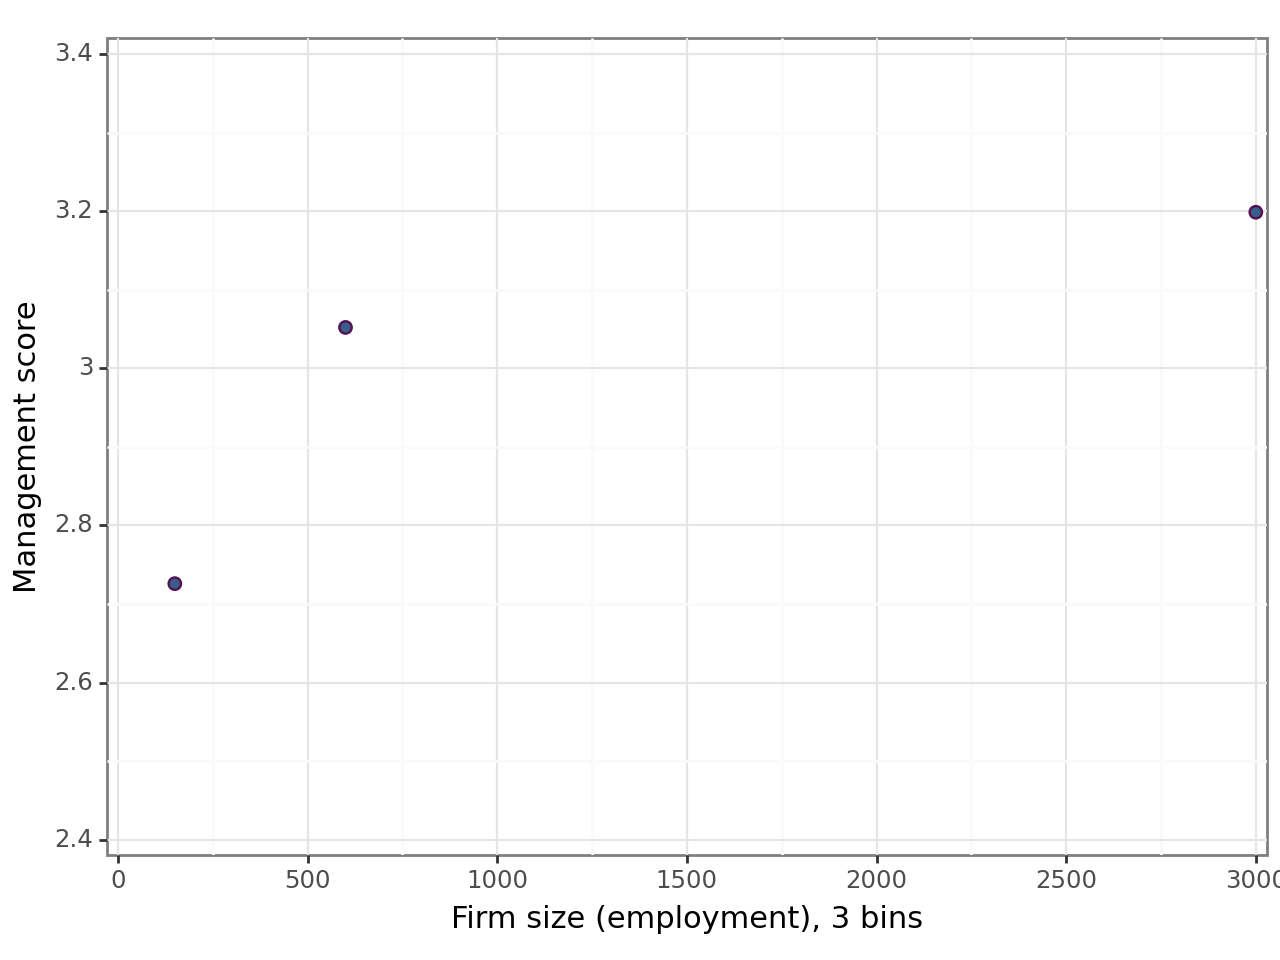

<Figure Size: (640 x 480)>

In [78]:
ggplot(df_mean, aes(x="emp3bins", y="management_emp3bins")) + geom_point(
    size=2, color=color[2], fill=color[0], alpha=0.8, na_rm=True
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(2.4, 3.4), breaks=seq(2.4, 3.5, by=0.2)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 3000), breaks=seq(0, 3005, by=500)
) + labs(
    x="Firm size (employment), 3 bins", y="Management score"
) + theme_bw()

Let's plot the PCA scatter bin.

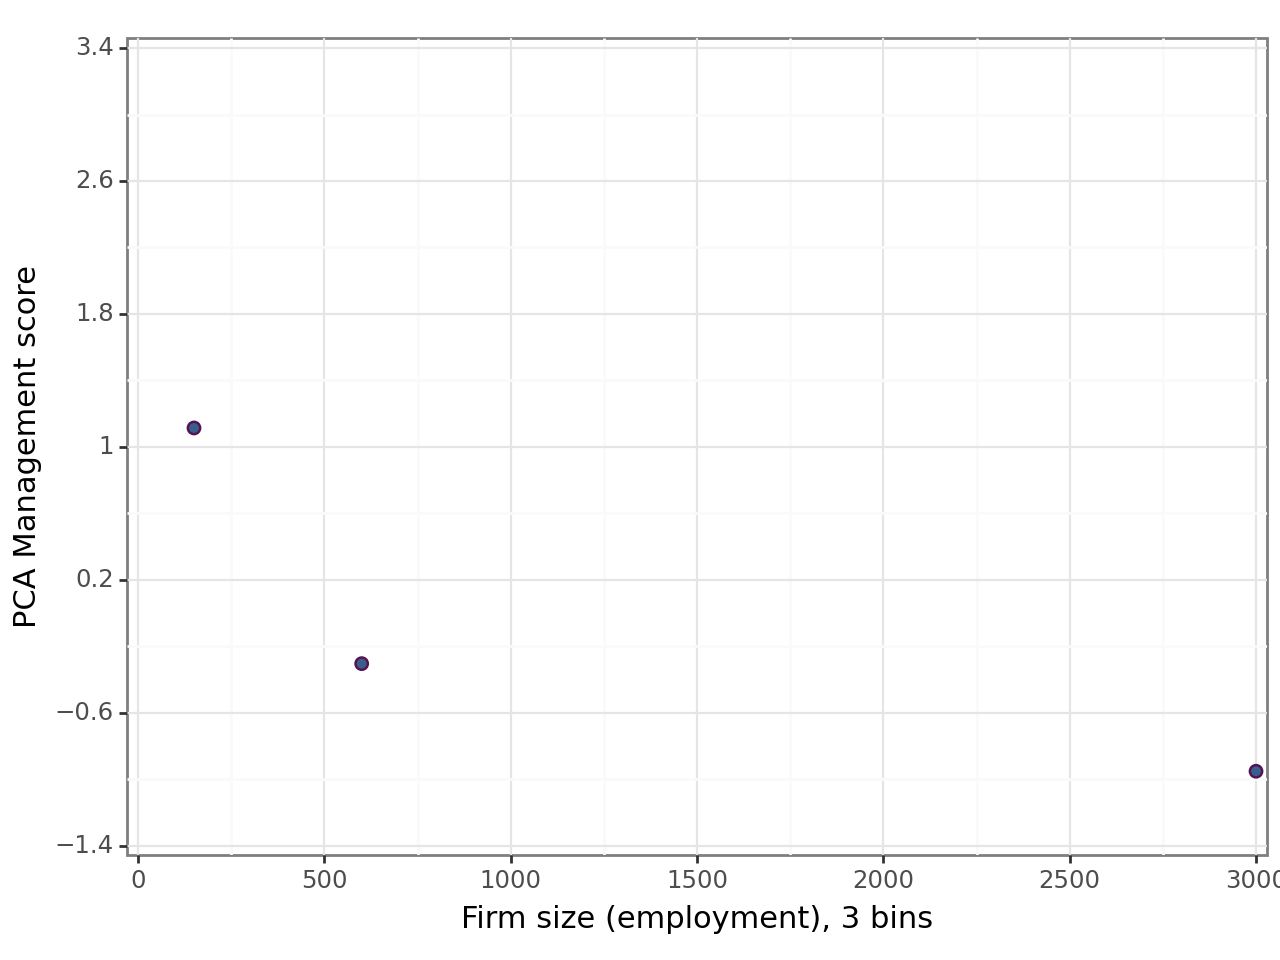

<Figure Size: (640 x 480)>

In [82]:
ggplot(df_pca, aes(x="emp3bins", y="PCA_management_emp3bins")) + geom_point(
    size=2, color=color[2], fill=color[0], alpha=0.8, na_rm=True
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(-1.4, 3.4), breaks=seq(-1.4, 3.5, by=0.8)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 3000), breaks=seq(0, 3005, by=500)
) + labs(
    x="Firm size (employment), 3 bins", y="PCA Management score"
) + theme_bw()

In [87]:
# Create a 10 bins for the number of employees in the firm
df["emp10bins"] = pd.cut(df["emp_firm"], bins=10)

# Summary
df_summary_10 = df.filter(["emp_firm", "emp10bins"]).groupby("emp10bins").agg(["min", "max", "mean", "median", np.std, "size"])
df_summary_10



emp_firm                                              
                      min     max         mean  median         std size
emp10bins                                                              
(95.1, 590.0]       100.0   550.0   231.592814   200.0  121.982774  167
(590.0, 1080.0]     600.0  1000.0   822.142857   800.0  149.897672   28
(1080.0, 1570.0]   1200.0  1500.0  1426.666667  1500.0  124.365054    6
(1570.0, 2060.0]   1700.0  2000.0  1953.333333  2000.0  106.009883   15
(2060.0, 2550.0]   2500.0  2500.0  2500.000000  2500.0         NaN    1
(2550.0, 3040.0]   2600.0  3000.0  2932.000000  3000.0  133.399983   10
(3040.0, 3530.0]   3500.0  3500.0  3500.000000  3500.0         NaN    1
(3530.0, 4020.0]   4000.0  4000.0  4000.000000  4000.0         NaN    1
(4020.0, 4510.0]      NaN     NaN          NaN     NaN         NaN    0
(4510.0, 5000.0]   4600.0  5000.0  4930.000000  5000.0  149.443412   10

In [89]:
# Recode employee bins
df = df.replace({"emp10bins": df_summary_10["emp_firm"]["mean"].to_dict()})

df.filter(["emp_firm", "emp10bins"]).groupby("emp10bins").agg(
    ["min", "max", "mean", "median", np.std, "size"])

emp_firm                                              
                        min     max         mean  median         std size
emp10bins                                                                
231.59281437125748    100.0   550.0   231.592814   200.0  121.982774  167
822.1428571428571     600.0  1000.0   822.142857   800.0  149.897672   28
1426.6666666666667   1200.0  1500.0  1426.666667  1500.0  124.365054    6
1953.3333333333333   1700.0  2000.0  1953.333333  2000.0  106.009883   15
2500.0               2500.0  2500.0  2500.000000  2500.0         NaN    1
2932.0               2600.0  3000.0  2932.000000  3000.0  133.399983   10
3500.0               3500.0  3500.0  3500.000000  3500.0         NaN    1
4000.0               4000.0  4000.0  4000.000000  4000.0         NaN    1
4930.0               4600.0  5000.0  4930.000000  5000.0  149.443412   10

In [90]:
# Geenrate variables by mean
df_10_mean = df.groupby("emp10bins").agg(management_emp10bins=("management", "mean")).reset_index()
df_10_mean

,emp10bins,management_emp10bins
0,231.592814,2.885230
1,822.142857,3.198413
2,1426.666667,3.037037
3,1953.333333,3.277778
4,2500.000000,3.388889
5,2932.000000,3.055556
6,3500.000000,4.000000
7,4000.000000,3.333333
8,4930.000000,3.255556


In [96]:
# Ensure the columns are of a continuous type
df_10_mean['emp10bins'] = df_10_mean['emp10bins'].astype(float)
df_10_mean['management_emp10bins'] = df_10_mean['management_emp10bins'].astype(float)

# Remove or fill NaN values
# df_10_mean = df_10_mean.dropna(subset=['emp10bins', 'management_emp10bins'])

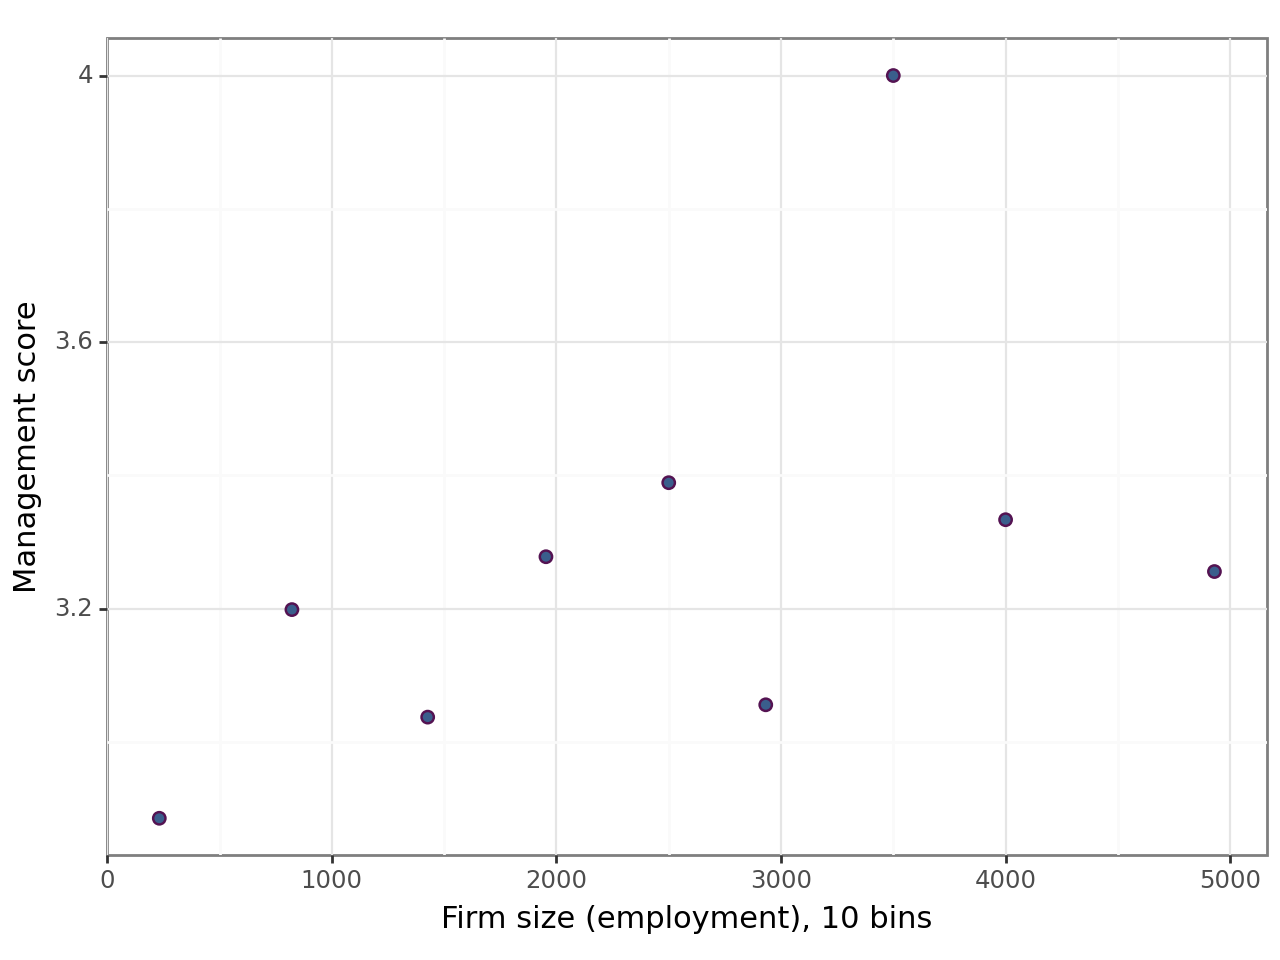

<Figure Size: (640 x 480)>

In [99]:
# Generate scatter plot of management score by firm size
ggplot(df_10_mean, aes(x="emp10bins", y="management_emp10bins")) + geom_point(
    size=2, color=color[2], fill=color[0], alpha=0.8, na_rm=True

)  + labs(
    x="Firm size (employment), 10 bins", y="Management score"
) + theme_bw()

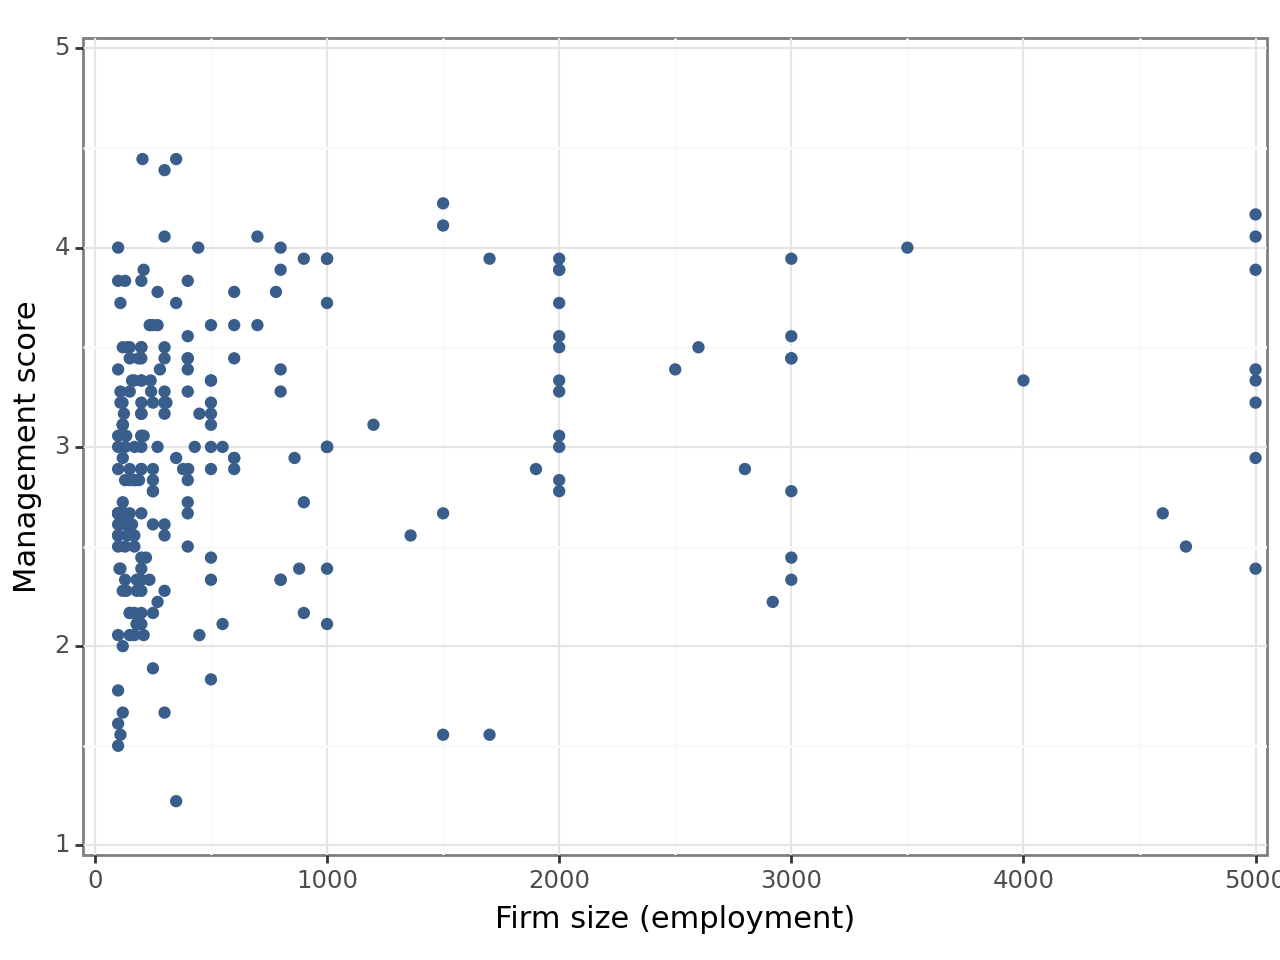

<Figure Size: (640 x 480)>

In [100]:
ggplot(df, aes(x="emp_firm", y="management")) + geom_point(
    color=color[0], size=1.5, alpha=0.8, show_legend=False, na_rm=True
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 5000), breaks=seq(0, 5001, by=1000)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 6, 1)
) + labs(
    x="Firm size (employment)", y="Management score"
) + theme_bw()


In [101]:
df['lnemp']=np.log(df['emp_firm'])

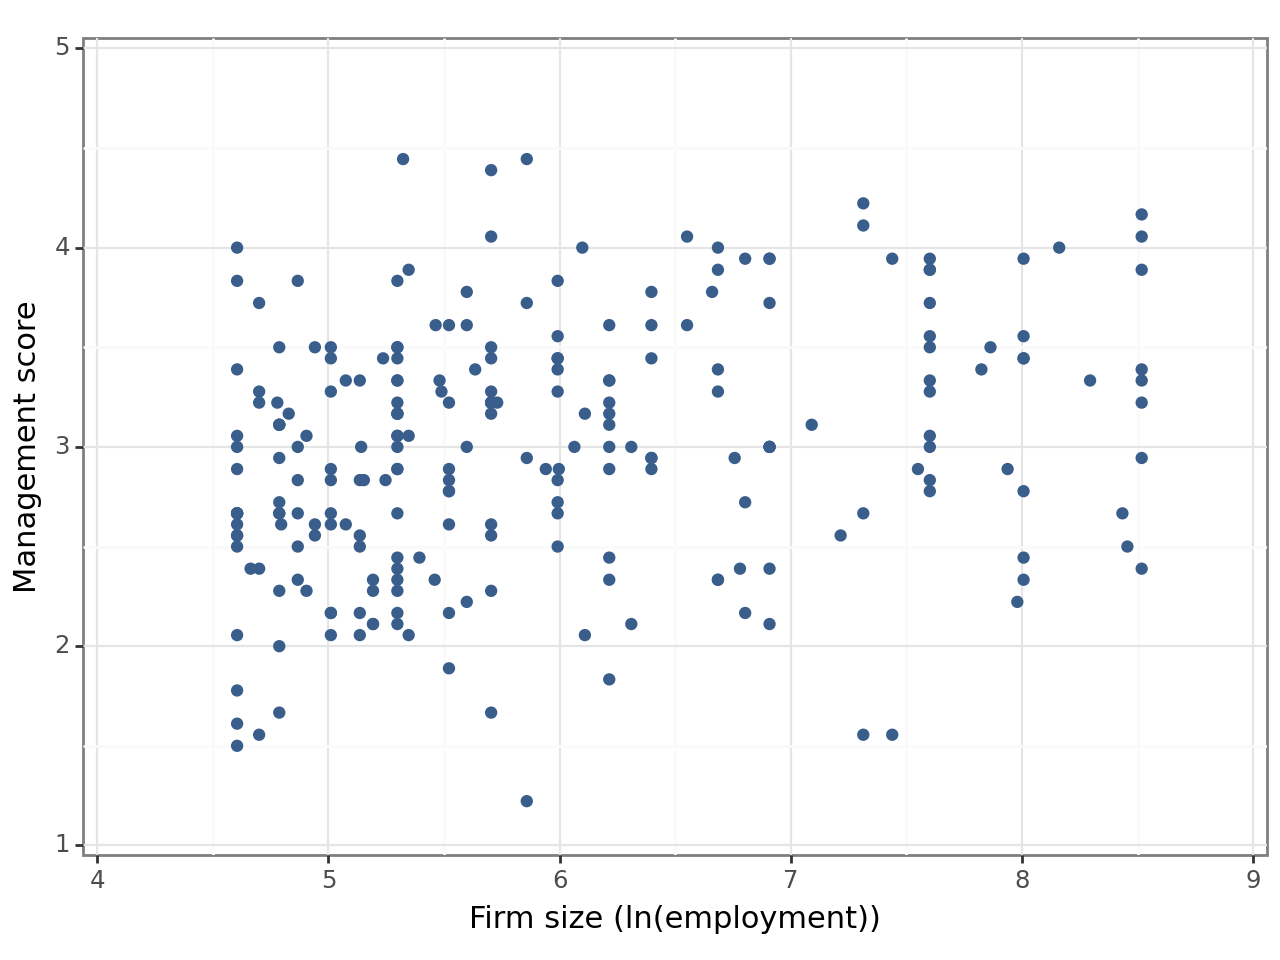

<Figure Size: (640 x 480)>

In [102]:
ggplot(df, aes(x="lnemp", y="management")) + geom_point(
    color=color[0], size=1.5, alpha=0.8, show_legend=False, na_rm=True
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(4, 9), breaks=seq(4, 10, by=1)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 6, 1)
) + labs(
    x="Firm size (ln(employment))", y="Management score"
) + theme_bw()

In [56]:
my_PCA.explained_variance_ratio_

array([0.41703966])

In [57]:
loadings = my_PCA.components_
print(f"Loadings:\n {loadings}")

Loadings:
 [[-0.26253254 -0.2435536  -0.28136226 -0.28865809 -0.28112512 -0.26517309
  -0.2210108  -0.25964193 -0.27824942 -0.23416807 -0.1409542  -0.22655397
  -0.24320555 -0.21312955 -0.10491626 -0.22422428 -0.1835115  -0.20168419]]


In [58]:
variables = data_columns.columns

In [59]:
loading_strength = pd.DataFrame({"variable": variables, "loading": loadings[0]},)
loading_strength["absolute_loading"] = loading_strength["loading"].abs()
loading_strength = loading_strength.sort_values(by='absolute_loading', ascending=False)


In [60]:
loading_strength

,variable,loading,absolute_loading
3,perf2,-0.288658,0.288658
2,perf1,-0.281362,0.281362
4,perf3,-0.281125,0.281125
8,perf7,-0.278249,0.278249
5,perf4,-0.265173,0.265173
0,lean1,-0.262533,0.262533
7,perf6,-0.259642,0.259642
1,lean2,-0.243554,0.243554
12,talent1,-0.243206,0.243206
9,perf8,-0.234168,0.234168


In [61]:
df["ln_emp_firm"] = np.log(df["emp_firm"])

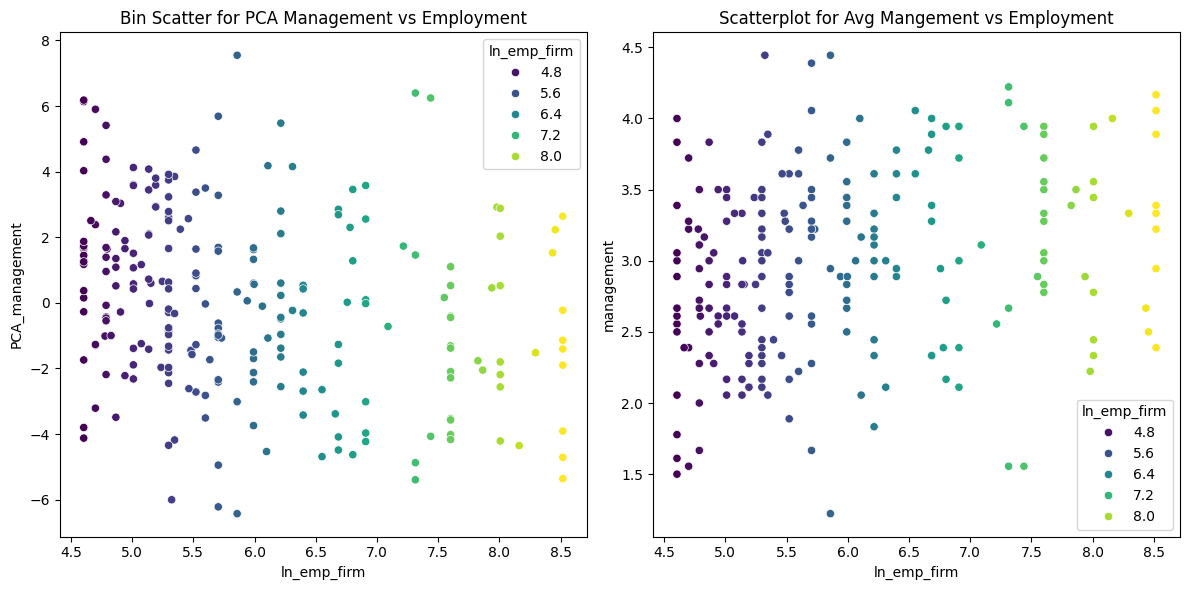

In [62]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(
    data=df,
    x="ln_emp_firm",
    y="PCA_management",
    hue="ln_emp_firm",
    palette="viridis",
)
plt.title("Bin Scatter for PCA Management vs Employment")

plt.subplot(1,2,2)
sns.scatterplot(
    data=df,
    x="ln_emp_firm",
    y="management",
    hue="ln_emp_firm",
    palette="viridis",
)

plt.title("Scatterplot for Avg Mangement vs Employment")
plt.tight_layout()
plt.show()

In [63]:
df.head()

,firmid,wave,cty,country,sic,management,operations,monitor,target,people,...,talent4,talent5,talent6,emp_firm,firmage,ownership,mne_yn,emp3bins,PCA_management,ln_emp_firm
12572,8882,2012,sg,Singapore,32.0,2.500000,2.5,2.4,2.8,2.333333,...,3.0,2.0,2.0,4700.0,NaN,Dispersed Shareholders,1.0,3000.0,2.227452,8.455318
12574,8884,2012,sg,Singapore,27.0,2.833333,3.0,3.6,3.0,2.000000,...,2.0,3.0,2.0,2000.0,63.0,Dispersed Shareholders,1.0,3000.0,0.525430,7.600902
12577,8887,2012,sg,Singapore,20.0,3.722222,3.5,4.0,4.2,3.166667,...,4.0,3.0,3.0,1000.0,55.0,"Family owned, family CEO",0.0,3000.0,-3.014086,6.907755
12579,8889,2012,sg,Singapore,20.0,3.055556,3.0,3.8,2.4,3.000000,...,3.0,2.0,4.0,2000.0,51.0,"Family owned, family CEO",0.0,3000.0,-0.407802,7.600902
12582,8892,2012,sg,Singapore,28.0,3.055556,4.0,3.2,3.2,2.500000,...,3.0,2.0,3.0,200.0,49.0,NaN,1.0,600.0,-0.259110,5.298317


In [64]:
df[["PCA_management"]].describe()

,PCA_management
count,2.390000e+02
mean,8.918946e-17
std,2.745588e+00
min,-6.425619e+00
25%,-1.894159e+00
50%,-3.303737e-02
75%,1.730965e+00
max,7.546862e+00
